# Convolutional autoencoder for image denoising<a class='tocSkip'>

**MSDS 2023 | COSCI223: Machine Learning 3**


*Prepared by Kristine Ann M. Carandang*


Building on what you have learned about autoencoders and CNNs so far, in this notebook, you will be designing and training a convolutional autoencoder for image denoising. 

Image denoising is one of the most common applications of autoencoders. 

Denoising autoencoder(DAE) is "an autoencoder that receives a corrupted data point as input and is trained to predict the original, uncorrupted data pointas its output" (Goodfellow, et al. 2018). Accordingly, a denoising convolutional autoencoder requires the training of "noisy" images (i.e., images with noise applied on them). Adding noise is illustrated in Item #3. This has been implemented for data preparation of medical images, facial recognition, and fault diagnosis of machinery among others.

In recent years, there have already been attempts to implement a denoising convolutional autoencoder without the presence of "clean" data (Clean data is typically the ground truth image used to calculate the reconstruction error loss).

For the following exercise, we will be using the Fasion MNIST dataset. During model training and evaluation, we will be adding noise to the images. Such "noisy" images will be our inputs to the model.

<div><span style="background-color:purple; padding-top: 100px; padding-right: 450px; padding-bottom: 50px; padding-left: 450px; color: #FFFFFF; font-size: 18px; font-weight: bold">EXERCISE</span></div>

**INSTRUCTIONS.**

Using this notebook:
1. Build an autoencoder (Item #4).
2. Select an optimizer (Item #8).
3. Train the autoencoder model (Item #9).
4. Evaluate the autoencoder model (Item #10).

Once you are satisfied with the results of your autoencoder, fill in the required information in the slide deck found in this [link](https://aimedu-my.sharepoint.com/:p:/g/personal/kcarandang_aim_edu/EYtfSeol2KlGmgyPeTs-JRQBZEcCtcYsaLOGdOZB_-SYPQ?e=dLdhJl) on the slide corresponding to your learning team. Also indicate your final test loss on Slide #2. Be ready to share your journey and results to the class.

# Load the libraries and functions

In [1]:
import numpy as np
import time 

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchsummary import summary

# For plotting
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
def train_and_validate(model, criterion, optimizer, n_epochs,
                       train_loader, val_loader):
    """Trains and validates a denoising autoencoder."""
    # Initialize lists to store outputs
    train_epoch_loss = []
    val_epoch_loss = []
    train_predictions = []
    val_predictions = []
    
    # Iterate through each epoch
    for epoch in range(n_epochs):

        print(f'Epoch:{epoch+1}')

        # Specify that the model is being trained
        model.train()

        # Initialize a list to store step loss
        train_step_loss = []



        # Iterate through each image
        for clean_image, _ in train_loader:

            # Get start time
            start_time = time.time()

            # Create a noisy version of the image
            noisy_image = ((clean_image +
                            torch.normal(0,0.2, clean_image.shape))
                           .clip(0,1)
                           .to(device=device))

            # Forward pass 
            reconstructed = model(noisy_image)

            # Calculate the reconstruction error
            training_loss = criterion(reconstructed,
                                      clean_image.to(device=device))

            # Make the parameter gradients zero
            optimizer.zero_grad()

            # Calculate the gradients
            training_loss.backward()

            # Update the weights
            optimizer.step()

            # Calculate execution time
            train_time = time.time() - start_time

            # Temporarily store the step loss
            train_step_loss.append(training_loss.item())

            # Store the predictions
            train_predictions.append((clean_image, reconstructed,
                                      training_loss, train_time))

        # Append mean training loss for each epoch
        train_epoch_loss.append(np.array(train_step_loss).mean())

        print(f'Training Loss: {training_loss.item():.4f},'
              f'\tExecution Time: {train_time:.4f}')


        # Specify that the model is being evaluated
        model.eval()

        # Initialize a list to store step loss
        val_step_loss = []

        # Specify that no gradients needed since evaluation is being done
        with torch.no_grad():

            for clean_val_image, _ in val_loader:

                # Get start time
                start_time = time.time()

                # Create a noisy version of the image
                noisy_val_image = ((clean_val_image +
                                    torch.normal(0,0.2,
                                                 clean_val_image.shape))
                               .clip(0,1)
                               .to(device=device))

                # Forward pass 
                reconstructed = model(noisy_val_image)

                # Calculate the reconstruction error
                val_loss = criterion(reconstructed,
                                     clean_val_image.to(device=device))

                # Calculate execution time
                val_time = time.time() - start_time

                # Temporarily store the step loss
                val_step_loss.append(val_loss.item())

            # Store the predictions
            val_predictions.append((clean_val_image, reconstructed,
                                    val_loss, val_time))

        # Append mean training loss for each epoch
        val_epoch_loss.append(np.array(val_step_loss).mean())

        print(f'Validation Loss:{val_loss.item():.4f},'
              f'\tExecution Time: {val_time:.4f}')
        print()
        
    # Collect outputs to return
    outputs = (train_epoch_loss, val_epoch_loss,
               train_predictions, val_predictions)

    return outputs
    

def evaluate(model, criterion, test_loader):
    """Tests a denoising autoencoder."""
    # Initialize lists to store outputs
    conso_test_loss = []
    predictions = []

    # Specify that the model is being evaluated
    model.eval()

    # Specify that no gradients needed since evaluation is being done
    with torch.no_grad():

        for clean_test_image, _ in test_loader:

            # Get start time
            start_time = time.time()

            # Create a noisy version of the image
            noisy_test_image = ((clean_test_image +
                                torch.normal(0,0.2, clean_test_image.shape))
                           .clip(0,1)
                           .to(device=device))

            # Forward pass 
            reconstructed = model(noisy_test_image)

            # Calculate the reconstruction error
            test_loss = criterion(reconstructed,
                                 clean_test_image.to(device=device))
            
            # Calculate execution time
            test_time = time.time() - start_time
            
            # Store test loss
            conso_test_loss.append(test_loss.item())

            # Store the predictions
            predictions.append((clean_test_image, reconstructed,
                                    test_loss, test_time))


            print(f'Test Loss:{test_loss.item():.4f},'
                  'f\tExecution Time: {test_time:.4f}')
            print()
        
    # Collect outputs to return
    outputs = (conso_test_loss, predictions)

    return outputs


def plot_performance(train_epoch_loss, val_epoch_loss):
    """Plots training and validation losses."""
    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Loss", weight='bold', fontsize=16)
    plt.plot(val_epoch_loss,label="Validation", color='purple')
    plt.plot(train_epoch_loss,label="Training", color='teal')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.legend();
    plt.show();


# Visualize samples of the dataset
def display_results(clean_data, noisy_data, title='Data'):
    """Shows sample images of results."""
    fig, ax = plt.subplots(3, 10, figsize=(15, 3))
    for i in range(10):
        image = clean_data[i].cpu()
        noisy_image = (image + torch.normal(0,0.2, image.shape)).clip(0,1)
        ax[0, i].imshow(noisy_image.permute(1,2,0).detach().numpy(),
                cmap='gray')
        ax[0, i].axis('off')
        ax[1, i].imshow(image.cpu().permute(1,2,0).detach().numpy(),
                        cmap='gray')
        ax[1, i].axis('off')
        ax[2, i].imshow(noisy_data[i].cpu().permute(1,2,0).detach().numpy(),
                    cmap='gray')
        ax[2, i].axis('off')
    plt.suptitle(title, weight='bold', fontsize=16)
    plt.show()

# Load the datasets

In [3]:
# Set seed
torch.manual_seed(8)

# Transform the numpy arrays to tensors
transform = transforms.ToTensor()

# Access the MNIST datasets from torchvision
fmnist_trainval_data = datasets.FashionMNIST(root='./data',
                                             train=True,
                                             download=True,
                                             transform=transform)
fmnist_train_data, fmnist_val_data = random_split(fmnist_trainval_data,
                                                  [0.7, 0.3])
fmnist_test_data = datasets.FashionMNIST(root='./data',
                                         train=False,
                                         download=True,
                                         transform=transform)

# Load the datasets
fmnist_train_loader = DataLoader(dataset=fmnist_train_data,
                                 batch_size=64,
                                 shuffle=True)
fmnist_val_loader = DataLoader(dataset=fmnist_val_data,
                               batch_size=64,
                               shuffle=True)
fmnist_test_loader = DataLoader(dataset=fmnist_test_data,
                                batch_size=64,
                                shuffle=True)

In [4]:
# Access the images from the MNIST train data
fmnist_train_dataiter = iter(fmnist_train_loader)
fmnist_train_images, fmnist_train_labels = next(fmnist_train_dataiter)

# Access the images from the MNIST validation data
fmnist_val_dataiter = iter(fmnist_val_loader)
fmnist_val_images, fmnist_val_labels = next(fmnist_val_dataiter)

# Access the images from the MNIST test data
fmnist_test_dataiter = iter(fmnist_test_loader)
fmnist_test_images, fmnist_test_labels = next(fmnist_test_dataiter)

# Add noise to the data

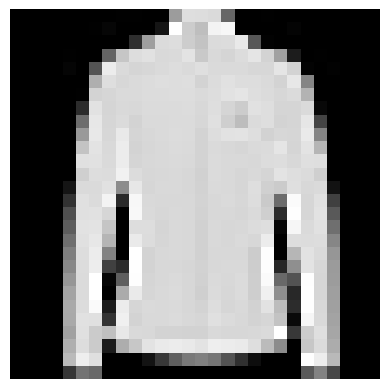

In [5]:
# Display a  sample image
image = fmnist_train_images[0]
plt.imshow(image.permute(1,2,0).detach().numpy(), cmap='gray');
plt.axis('off');

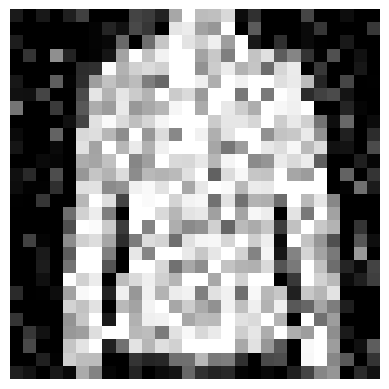

In [6]:
# Add noise to the sample image
noisy_image = (image + torch.normal(0,0.2, image.shape)).clip(0,1)

# Display the noisy image
plt.imshow(noisy_image.permute(1,2,0).detach().numpy(), cmap='gray');
plt.axis('off');

In [7]:
# Add noise to the data
noisy_train_images = (fmnist_train_images +
                      torch.normal(0,0.2, image.shape)).clip(0,1)
noisy_val_images = (fmnist_val_images +
                    torch.normal(0,0.2, image.shape)).clip(0,1)
noisy_test_images = (fmnist_test_images +
                     torch.normal(0,0.2, image.shape)).clip(0,1)

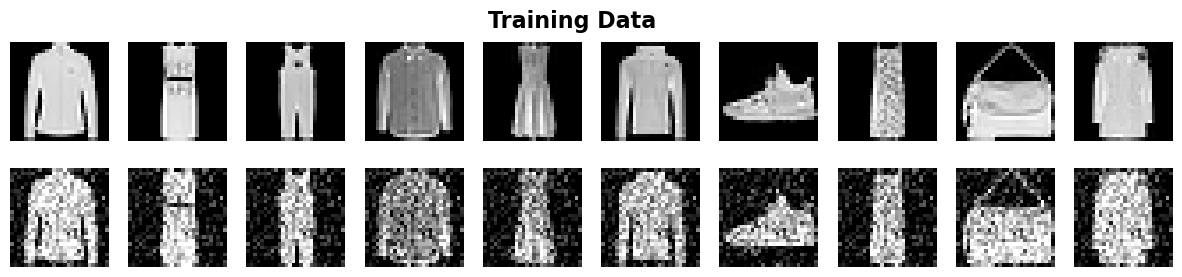

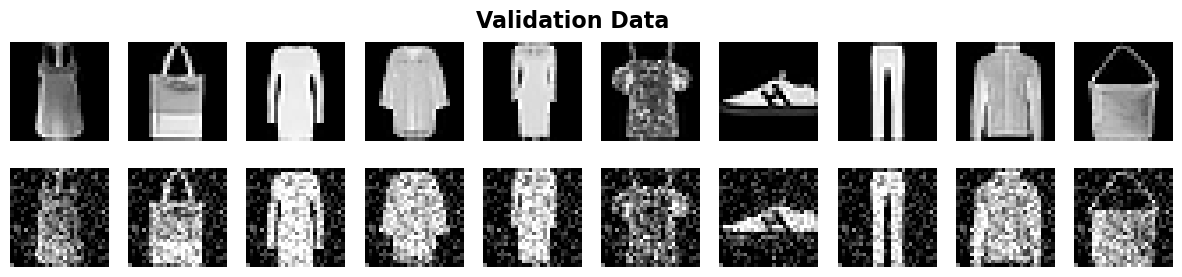

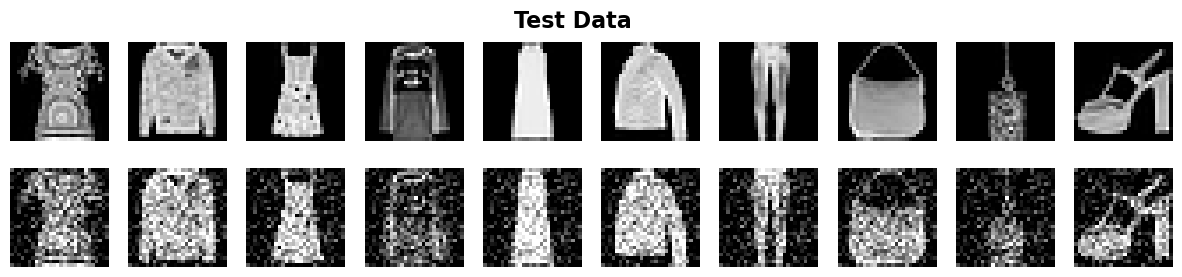

In [8]:
# Visualize samples of the dataset
def plot_samples(clean_data, noisy_data, title='Data'):
    fig, ax = plt.subplots(2, 10, figsize=(15, 3))
    for i in range(10):
        ax[0, i].imshow(clean_data[i].permute(1,2,0).detach().numpy(),
                        cmap='gray')
        ax[0, i].axis('off')
        ax[1, i].imshow(noisy_data[i].permute(1,2,0).detach().numpy(),
                    cmap='gray')
        ax[1, i].axis('off')
    plt.suptitle(title, weight='bold', fontsize=16)
    plt.show()

plot_samples(fmnist_train_images, noisy_train_images, 'Training Data')
plot_samples(fmnist_val_images, noisy_val_images, 'Validation Data')
plot_samples(fmnist_test_images, noisy_test_images, 'Test Data')

<div class="alert-danger alert-block">
   <br>
  <strong> IMPORTANT NOTE:</strong> <br>Adding the noise this way only applies to one batch of images. Adding noise should be incorporated during model training and evaluation.
    <br>
    <br>
</div>

# Build an autoencoder

In [9]:
class Autoencoder(nn.Module):
    def __init__(self):
        
        super().__init__()        
        
        # Encoder block
        self.encoder = nn.Sequential(
            

        )
        
        # Decoder block
        self.decoder = nn.Sequential(
            

        )

    def forward(self, x):
        bottleneck = self.encoder(x)
        reconstructed = self.decoder(bottleneck)
        return reconstructed

# Initialize the model

In [10]:
# Initialize the model
model = Autoencoder()

# Load the model to the device used

In [11]:
# Check the device you are using
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on {device}.")

Training on cuda.


In [ ]:
# Load the model to the device used
model.to(device)

# Initialize the loss function

In [13]:
# Initialize the loss function
criterion = nn.MSELoss()

# Select an optimizer

In [14]:
# Initialize the optimizer function
optimizer = 

# Train the autoencoder model

In [15]:
# Train the model
outputs = train_and_validate(model, criterion, optimizer, 10,
                             fmnist_train_loader, fmnist_val_loader)

Epoch:1
Training Loss: 0.0058,	Execution Time: 0.0166
Validation Loss:0.0062,	Execution Time: 0.0018

Epoch:2
Training Loss: 0.0067,	Execution Time: 0.0038
Validation Loss:0.0044,	Execution Time: 0.0018

Epoch:3
Training Loss: 0.0056,	Execution Time: 0.0056
Validation Loss:0.0048,	Execution Time: 0.0014

Epoch:4
Training Loss: 0.0063,	Execution Time: 0.0043
Validation Loss:0.0048,	Execution Time: 0.0015

Epoch:5
Training Loss: 0.0046,	Execution Time: 0.0053
Validation Loss:0.0056,	Execution Time: 0.0015

Epoch:6
Training Loss: 0.0041,	Execution Time: 0.0055
Validation Loss:0.0058,	Execution Time: 0.0016

Epoch:7
Training Loss: 0.0050,	Execution Time: 0.0060
Validation Loss:0.0066,	Execution Time: 0.0014

Epoch:8
Training Loss: 0.0041,	Execution Time: 0.0048
Validation Loss:0.0051,	Execution Time: 0.0015

Epoch:9
Training Loss: 0.0051,	Execution Time: 0.0050
Validation Loss:0.0058,	Execution Time: 0.0014

Epoch:10
Training Loss: 0.0046,	Execution Time: 0.0042
Validation Loss:0.0056,	Exe

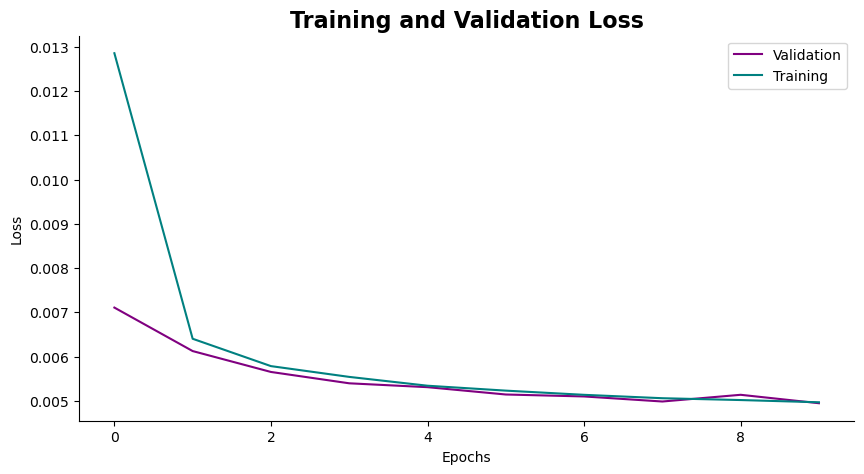

In [16]:
# Plot the training and validation losses
plot_performance(outputs[0], outputs[1])

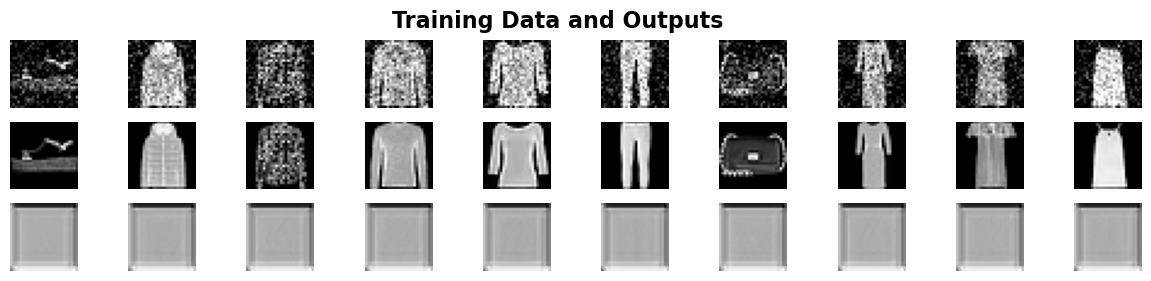

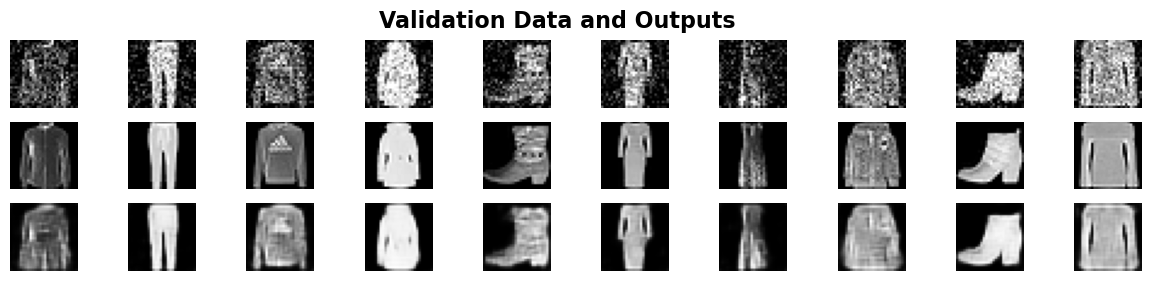

In [17]:
# Plot sample results on training
display_results(outputs[2][0][0],
                outputs[2][0][1],
                'Training Data and Outputs')

# Plot sample results on validation
display_results(outputs[3][0][0],
                outputs[3][0][1],
                'Validation Data and Outputs')

# Evaluate the autoencoder model

In [18]:
# Evaluate the model
test_outputs = evaluate(model, criterion, fmnist_test_loader)

Test Loss:0.0049,	Execution Time: 0.0043

Test Loss:0.0051,	Execution Time: 0.0038

Test Loss:0.0051,	Execution Time: 0.0038

Test Loss:0.0048,	Execution Time: 0.0038

Test Loss:0.0044,	Execution Time: 0.0039

Test Loss:0.0051,	Execution Time: 0.0039

Test Loss:0.0048,	Execution Time: 0.0039

Test Loss:0.0047,	Execution Time: 0.0038

Test Loss:0.0048,	Execution Time: 0.0038

Test Loss:0.0048,	Execution Time: 0.0038

Test Loss:0.0052,	Execution Time: 0.0038

Test Loss:0.0046,	Execution Time: 0.0038

Test Loss:0.0049,	Execution Time: 0.0038

Test Loss:0.0045,	Execution Time: 0.0038

Test Loss:0.0051,	Execution Time: 0.0038

Test Loss:0.0049,	Execution Time: 0.0040

Test Loss:0.0055,	Execution Time: 0.0038

Test Loss:0.0051,	Execution Time: 0.0039

Test Loss:0.0049,	Execution Time: 0.0039

Test Loss:0.0053,	Execution Time: 0.0040

Test Loss:0.0053,	Execution Time: 0.0039

Test Loss:0.0044,	Execution Time: 0.0038

Test Loss:0.0051,	Execution Time: 0.0038

Test Loss:0.0046,	Execution Time: 

In [21]:
# Get the mean of the test losses
display(np.mean(test_outputs[0]))

0.0049572187552976

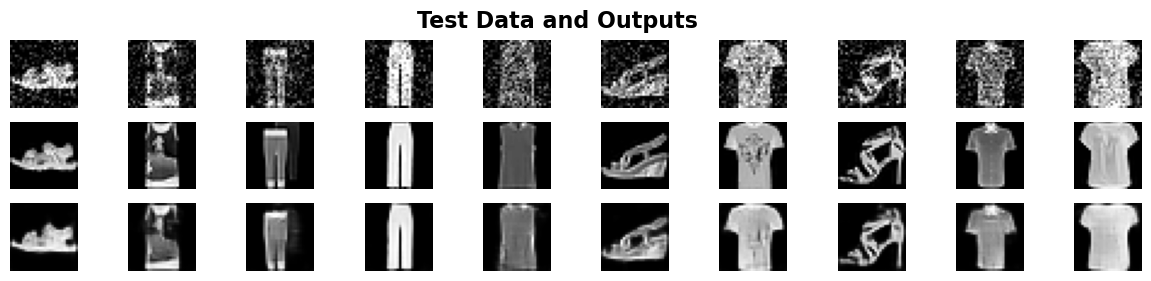

In [22]:
# Plot sample test results
display_results(test_outputs[1][0][0],
                test_outputs[1][0][1],
                'Test Data and Outputs')

# References <a class='tocSkip'>

- PyTorch Documentation
- Original Paper (2006): https://science.sciencemag.org/content/313/5786/504
- Textbook: https://www.deeplearningbook.org/contents/autoencoders.html
- Textbook: https://frcs.github.io/4C16-LectureNotes/autoencoders.html
- Code-along in PyTorch: https://www.youtube.com/watch?v=zp8clK9yCro
- Tutorial: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
- Javier, P. (2022). Autoencoders lecture.